# Import Packages

In [2]:
import h5py
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import pickle
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Read and Proprocess Data

## Read Data

In [4]:
matFilename = 'data/2018-02-20_batchdata_updated_struct_errorcorrect.mat'
f = h5py.File(matFilename, 'r')

In [5]:
list(f.keys())

['#refs#', '#subsystem#', 'batch', 'batch_date']

In [6]:
batch = f['batch']

In [7]:
list(batch.keys())

['Vdlin',
 'barcode',
 'channel_id',
 'cycle_life',
 'cycles',
 'policy',
 'policy_readable',
 'summary']

## Preprocess Data

In [8]:
num_cells = batch['summary'].shape[0]

bat_dict = {}

for i in range(num_cells):
    # Cycle life
    cl = np.array(f[batch['cycle_life'][i, 0]])

    # Decode MATLAB string
    policy_bytes = np.array(f[batch['policy_readable'][i, 0]])
    policy = ''.join([chr(c[0]) if isinstance(c, np.ndarray) else chr(c) for c in policy_bytes])

    # Summary
    summary_group = f[batch['summary'][i, 0]]
    summary = {}
    for key in summary_group.keys():
        data = summary_group[key][0, :]
        # Dereference if needed
        arr_list = []
        for item in data:
            if isinstance(item, h5py.Reference):
                arr_list.append(np.array(f[item]))
            else:
                arr_list.append(np.array(item))
        summary[key] = np.hstack(arr_list)

    # Cycles
    cycles_group = f[batch['cycles'][i, 0]]
    cycle_dict = {}
    for j in range(cycles_group['I'].shape[0]):
        cd = {}
        for field in cycles_group.keys():
            dataset = cycles_group[field][j, 0]
            if isinstance(dataset, h5py.Reference):
                cd[field] = np.array(f[dataset])
            else:
                cd[field] = np.array(dataset)
        cycle_dict[str(j)] = cd

    bat_dict[f'b1c{i}'] = {
        'cycle_life': cl,
        'charge_policy': policy,
        'summary': summary,
        'cycles': cycle_dict
    }

print(f"Loaded {len(bat_dict)} cells successfully.")


Loaded 47 cells successfully.


## Examine Data

In [9]:
bat_dict.keys()

dict_keys(['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4', 'b1c5', 'b1c6', 'b1c7', 'b1c8', 'b1c9', 'b1c10', 'b1c11', 'b1c12', 'b1c13', 'b1c14', 'b1c15', 'b1c16', 'b1c17', 'b1c18', 'b1c19', 'b1c20', 'b1c21', 'b1c22', 'b1c23', 'b1c24', 'b1c25', 'b1c26', 'b1c27', 'b1c28', 'b1c29', 'b1c30', 'b1c31', 'b1c32', 'b1c33', 'b1c34', 'b1c35', 'b1c36', 'b1c37', 'b1c38', 'b1c39', 'b1c40', 'b1c41', 'b1c42', 'b1c43', 'b1c44', 'b1c45', 'b1c46'])

In [10]:
bat_dict['b1c0']['summary'].keys()

dict_keys(['IR', 'QCharge', 'QDischarge', 'Tavg', 'Tmax', 'Tmin', 'chargetime', 'cycle'])

#### QDischarge

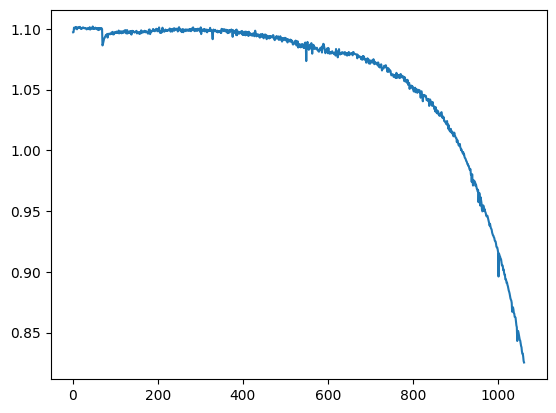

In [11]:
plt.plot(bat_dict['b1c43']['summary']['cycle'], bat_dict['b1c43']['summary']['QDischarge'])

#### QCharge

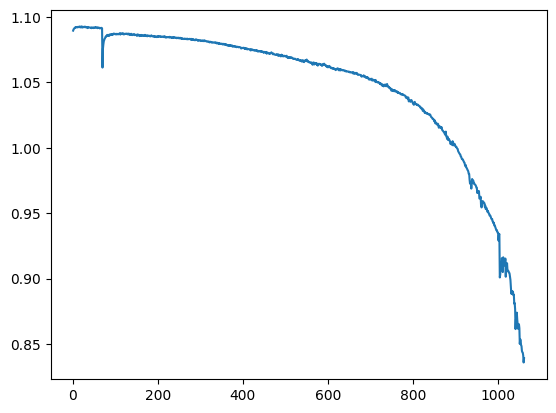

In [12]:
plt.plot(bat_dict['b1c43']['summary']['cycle'], bat_dict['b1c43']['summary']['QCharge'])

#### Tavg

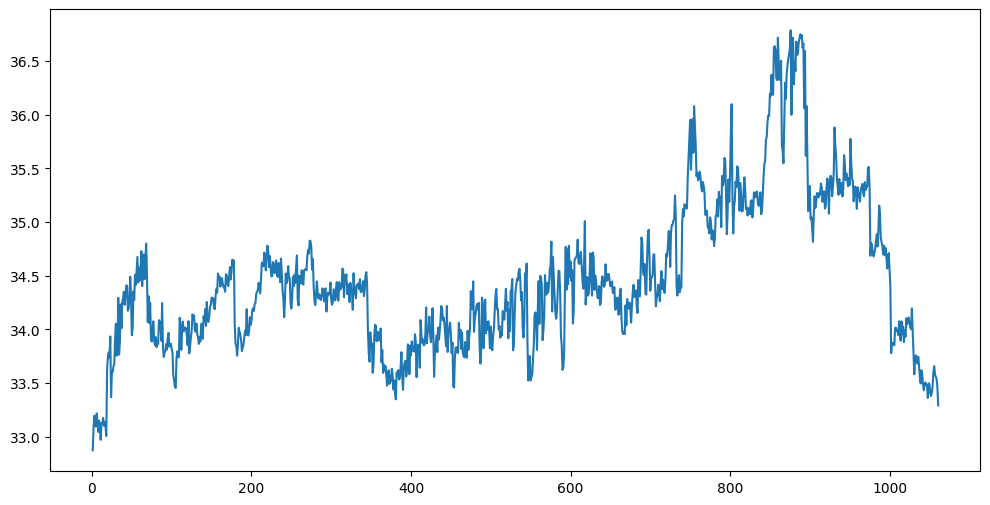

In [13]:
plt.figure(figsize=(12,6))
plt.plot(bat_dict['b1c43']['summary']['cycle'], bat_dict['b1c43']['summary']['Tavg'])

#### Tmax

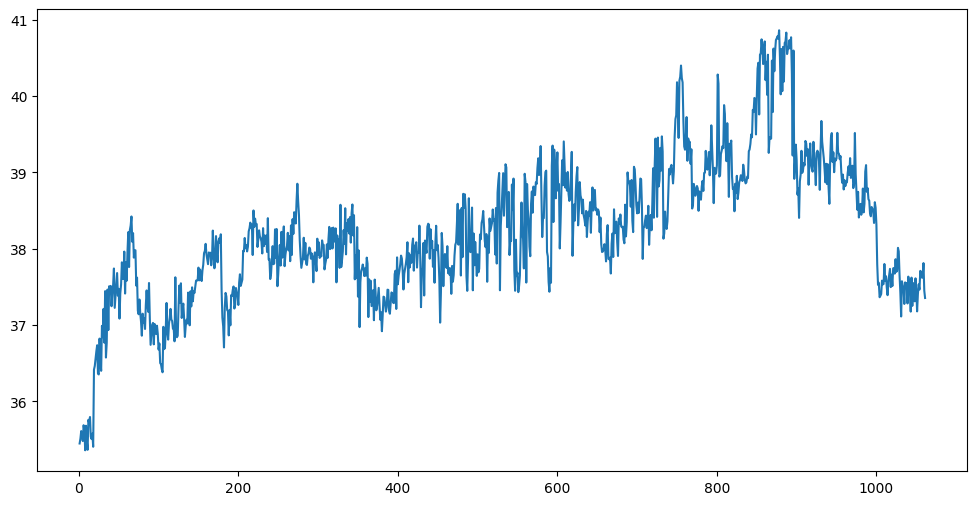

In [14]:
plt.figure(figsize=(12,6))
plt.plot(bat_dict['b1c43']['summary']['cycle'], bat_dict['b1c43']['summary']['Tmax'])

#### Tmin

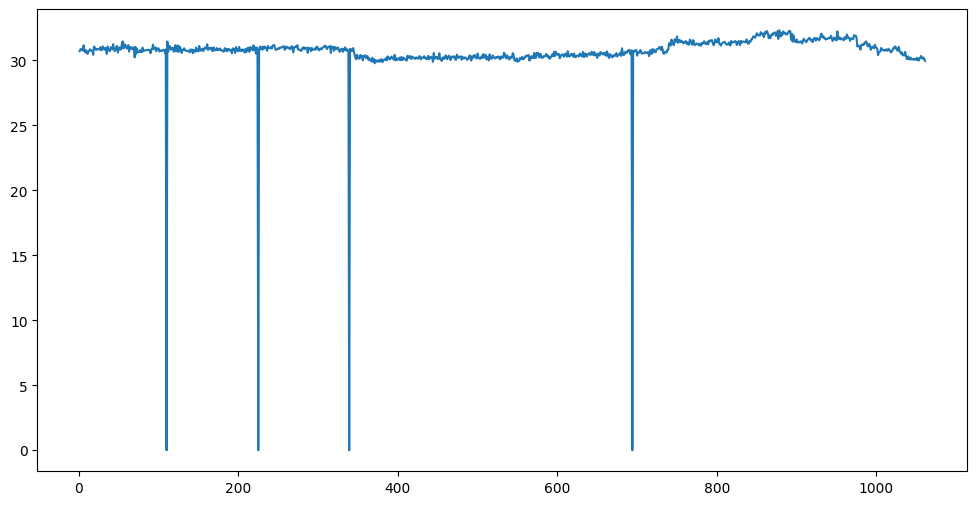

In [15]:
plt.figure(figsize=(12,6))
plt.plot(bat_dict['b1c43']['summary']['cycle'], bat_dict['b1c43']['summary']['Tmin'])

#### chargetime

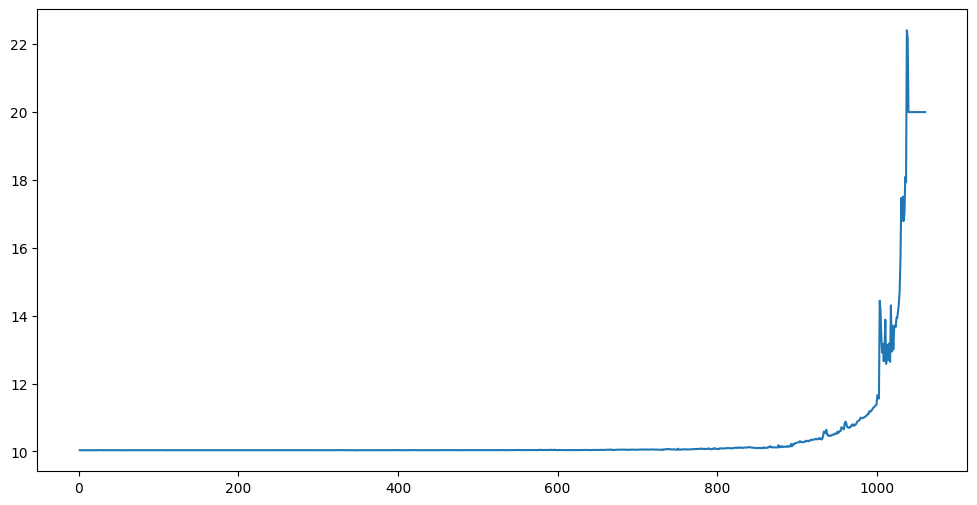

In [16]:
plt.figure(figsize=(12,6))
plt.plot(bat_dict['b1c43']['summary']['cycle'], bat_dict['b1c43']['summary']['chargetime'])

#### IR

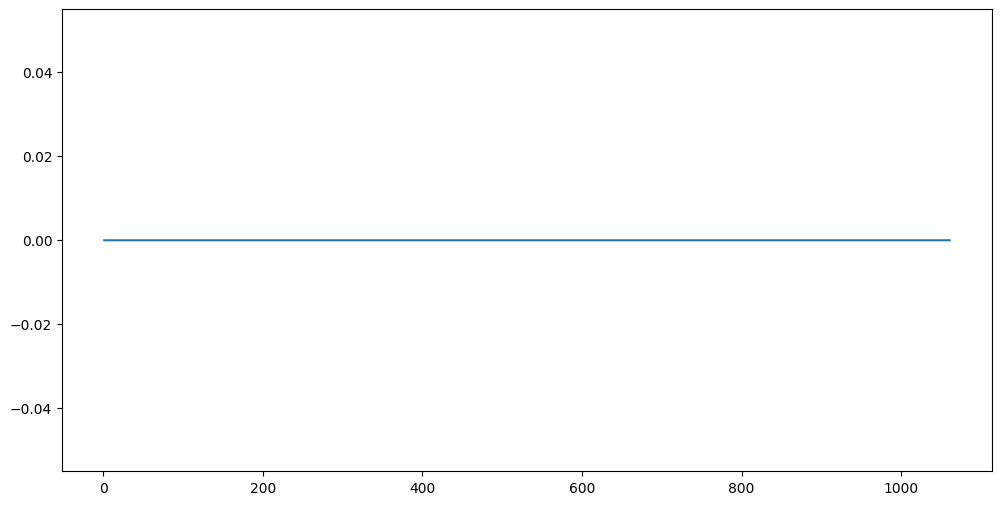

In [17]:
plt.figure(figsize=(12,6))
plt.plot(bat_dict['b1c43']['summary']['cycle'], bat_dict['b1c43']['summary']['IR'])

## Data Description

1. IR--Internal Resistance for the current
2. QCharge--Charge capacity. Units are usually Ah. Declines over time due to material degradation.
3. QDischarge--Discharge capacity. Units are usually Ah. Declines over time. 
4. Tavg--Mean operating temperature during a cycle. 
5. Tmax--Maximum operating temperatue during a cycle. 
6. Tmin--Minimum operating temperature during a cycle.
7. chargetime--Time taken to charge.
8. cycle--Cycle is the count of charge–discharge loops.

# Functions for Prediction

## Training Features = 1

In [20]:
def train_lstm(cycles, train, window_size=10, epochs=50, batch_size=16):
    
    # Convert to numpy arrays
    train = np.array(train).reshape(-1, 1)
    
    # Scale data between 0 and 1
    scaler = MinMaxScaler()
    q_scaled = scaler.fit_transform(train)
    
    # Train-test split (80-20)
    split_idx = int(len(q_scaled) * 0.8)
    train, test = q_scaled[:split_idx], q_scaled[split_idx:]
    
    # Function to create sequences
    def create_sequences(data, window_size):
        X, y = [], []
        for i in range(len(data) - window_size):
            X.append(data[i:i+window_size])
            y.append(data[i+window_size])
        return np.array(X), np.array(y)
    
    X_train, y_train = create_sequences(train, window_size)
    X_test, y_test = create_sequences(test, window_size)
    
    # Reshape for LSTM (samples, timesteps, features)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    # Build LSTM model
    model = Sequential([
        LSTM(50, activation='tanh', input_shape=(window_size, 1)),
        Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)
    
    return model, scaler, X_test, y_test

In [ ]:
def test_lstm(model, scaler, X_test, y_test):

    # Predictions
    y_pred = model.predict(X_test)
    
    # Inverse transform back to original scale
    y_pred = scaler.inverse_transform(y_pred)
    y_test = scaler.inverse_transform(y_test)

    return y_pred, y_test

In [ ]:
def plot_predict(y_pred, y_test):

    plt.figure(figsize=(10,6))
    plt.plot(range(len(y_test)), y_test, label="True QDischarge", color="blue")
    plt.plot(range(len(y_pred)), y_pred, label="Predicted QDischarge", color="red", linestyle="dashed")
    plt.xlabel("Cycle Index (Test Set)")
    plt.ylabel("QDischarge")
    plt.legend()
    plt.title("LSTM Prediction of Battery Capacity Fade")
    plt.show()
    
    return

In [ ]:
cycles = bat_dict['b1c43']['summary']['cycle']
q_discharge = bat_dict['b1c43']['summary']['QDischarge']
q_charge = bat_dict['b1c43']['summary']['QCharge']
t_avg = bat_dict['b1c43']['summary']['Tavg']


model_qd, scaler_qd, X_test_qd, y_test_qd = train_lstm(cycles, q_discharge, window_size=20, epochs=30)
model_qc, scaler_qc, X_test_qc, y_test_qc = train_lstm(cycles, q_charge, window_size=20, epochs=30)
model_ta, scaler_ta, X_test_ta, y_test_ta = train_lstm(cycles, t_avg, window_size=20, epochs=30)

In [ ]:
plot_predict(y_pred_qd, y_test_qd)

In [ ]:
plot_predict(y_pred_qc, y_test_qc)

In [ ]:
plot_predict(y_pred_ta, y_test_ta)

## Training Features = n (Multivariate)

### Function to Train

In [24]:
def train_lstm_multivariate(cycles, features, target, window_size=10, epochs=50, batch_size=16):
    # Convert to numpy arrays
    features = np.array(features)
    target = np.array(target).reshape(-1, 1)

    # Scale features and target separately
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    features_scaled = scaler_X.fit_transform(features)
    target_scaled = scaler_y.fit_transform(target)

    # Train-test split (80-20)
    split_idx = int(len(features_scaled) * 0.8)
    train_X, test_X = features_scaled[:split_idx], features_scaled[split_idx:]
    train_y, test_y = target_scaled[:split_idx], target_scaled[split_idx:]

    # Create sequences
    def create_sequences(data_X, data_y, window_size):
        X, y = [], []
        for i in range(len(data_X) - window_size):
            X.append(data_X[i:i+window_size])
            y.append(data_y[i+window_size])
        return np.array(X), np.array(y)

    X_train, y_train = create_sequences(train_X, train_y, window_size)
    X_test, y_test = create_sequences(test_X, test_y, window_size)

    # Build LSTM model
    model = Sequential([
        LSTM(100, activation='tanh', input_shape=(window_size, features.shape[1])),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

    return model, scaler_X, scaler_y, X_test, y_test

### Function to Test

In [23]:
def test_lstm(model, scaler_y, X_test, y_test):
    # Predictions
    y_pred = model.predict(X_test)

    # Inverse transform back to original scale
    y_pred = scaler_y.inverse_transform(y_pred)
    y_test = scaler_y.inverse_transform(y_test)

    return y_pred, y_test

### Function to Predict

In [22]:
def plot_predict(y_pred, y_test, y_title, y_label):

    plt.figure(figsize=(10,6))
    plt.plot(range(len(y_test)), y_test, label="Actual", color="blue")
    plt.plot(range(len(y_pred)), y_pred, label=y_label, color="red", linestyle="dashed")
    plt.xlabel("Cycles")
    plt.ylabel(y_title)
    plt.legend()
    plt.title("LSTM Prediction of Battery Capacity Fade")
    plt.show()
    
    return

### Function to Find Errors

In [25]:
def evaluate_predictions(y_true, y_pred):

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)

    # Avoid division by zero in MAPE
    non_zero_idx = y_true != 0
    mape = np.mean(np.abs((y_true[non_zero_idx] - y_pred[non_zero_idx]) / y_true[non_zero_idx])) * 100

    return {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "MAPE (%)": mape
    }


## Prediction

### Train (Tavg, Tmax, Tmin) -> Predict (Tavg)

Epoch 1/50


/Users/manojherath/PythonProjects/BatteryAnalysis/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0191
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0038
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0033
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0030
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0030
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027
Epoch 9/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0027
Epoch 10/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0026
Epoch 11/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0027
Epoch 12/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025
Epoch 13/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0024
Epoch 14/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0024
Epoch 15/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0026
Epoch 16/50
53/53 ━━━━━━━━━━━━

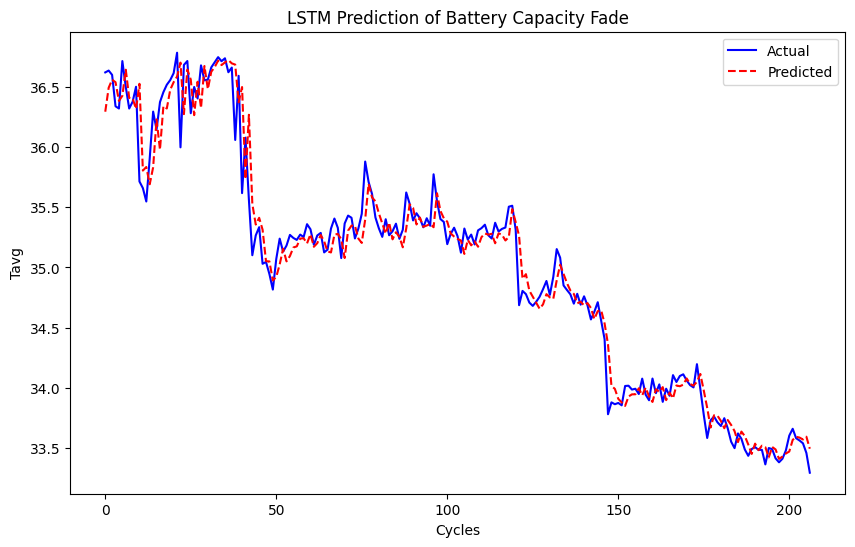

{'MAE': 0.12694041326409283,
 'MSE': 0.03664204578950506,
 'RMSE': np.float64(0.19142112158668662),
 'MAPE (%)': np.float64(0.35997710471409905)}

In [26]:
summary = bat_dict['b1c43']['summary']

# Select features and target
features = np.column_stack([
    #summary['QDischarge'],  # include target as input too (optional)
    #summary['QCharge'],
    summary['Tavg'],
    summary['Tmax'],
    summary['Tmin'],
    #summary['chargetime']
])

target_name = 'Tavg'
target = summary[target_name]  # what we want to predict

# Train
model, scaler_X, scaler_y, X_test, y_test = train_lstm_multivariate(
    summary['cycle'], features, target, window_size=6, epochs=50
)

#model.save(f"pred_models/for_Qcharge_Qcharge_discharge.keras") # Save the trained model

#model = tf.keras.models.load_model(f"pred_models/for_Tavg_Tavg_max_min.keras")

y_pred, y_true = test_lstm(model, scaler_y, X_test, y_test)

plot_predict(y_pred, y_true, y_title=target_name, y_label = "Predicted")

evaluate_predictions(y_true, y_pred)


### Train (QDischarge, Qcharge) -> Predict (QCharge)

Epoch 1/50


/Users/manojherath/PythonProjects/BatteryAnalysis/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0916 
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.4907e-04
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.3334e-04
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0829e-04
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.7831e-04
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4946e-04
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2404e-04
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0180e-04
Epoch 9/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7510e-04
Epoch 10/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5149e-04
Epoch 11/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3127e-04
Epoch 12/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1640e-04
Epoch 13/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0144e-04
Epoch 14/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.3010e-05
Epoch 15/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2

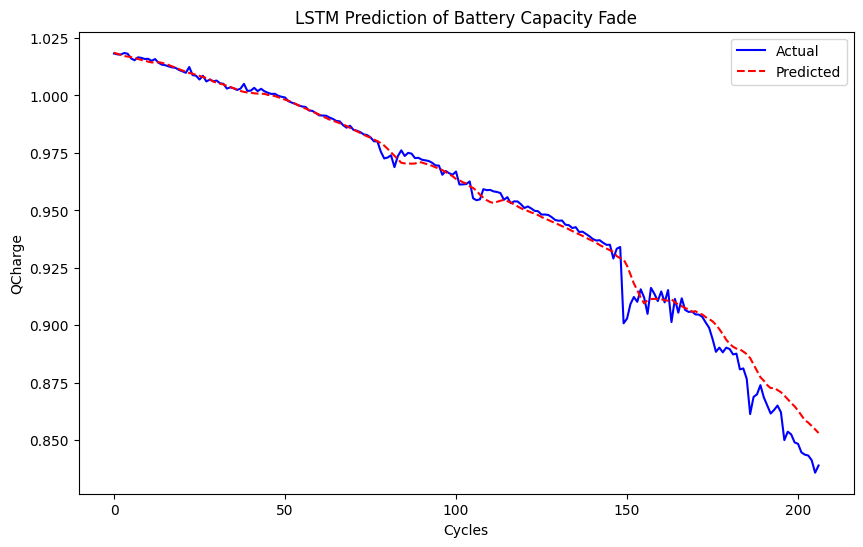

{'MAE': 0.0033548212084010044,
 'MSE': 3.390924127301876e-05,
 'RMSE': np.float64(0.005823164197669405),
 'MAPE (%)': np.float64(0.3729980416359065)}

In [33]:
summary = bat_dict['b1c43']['summary']

# Select features and target
features = np.column_stack([
    summary['QDischarge'],  # include target as input too (optional)
    summary['QCharge'],
    #summary['Tavg'],
    #summary['Tmax'],
    #summary['Tmin'],
    #summary['chargetime']
])

target_name = 'QCharge'
target = summary[target_name]  # what we want to predict

# Train
model, scaler_X, scaler_y, X_test, y_test = train_lstm_multivariate(
    summary['cycle'], features, target, window_size=6, epochs=50
)

#model.save(f"pred_models/for_Qcharge_Qcharge_discharge.keras") # Save the trained model

#model = tf.keras.models.load_model(f"pred_models/for_Tavg_Tavg_max_min.keras")

y_pred, y_true = test_lstm(model, scaler_y, X_test, y_test)

plot_predict(y_pred, y_true, y_title=target_name, y_label = "Predicted")

evaluate_predictions(y_true, y_pred)


## Simulation

In [27]:
float(np.mean(y_pred))

35.014190673828125

In [30]:
float(np.mean(y_sim))

34.44435501098633

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


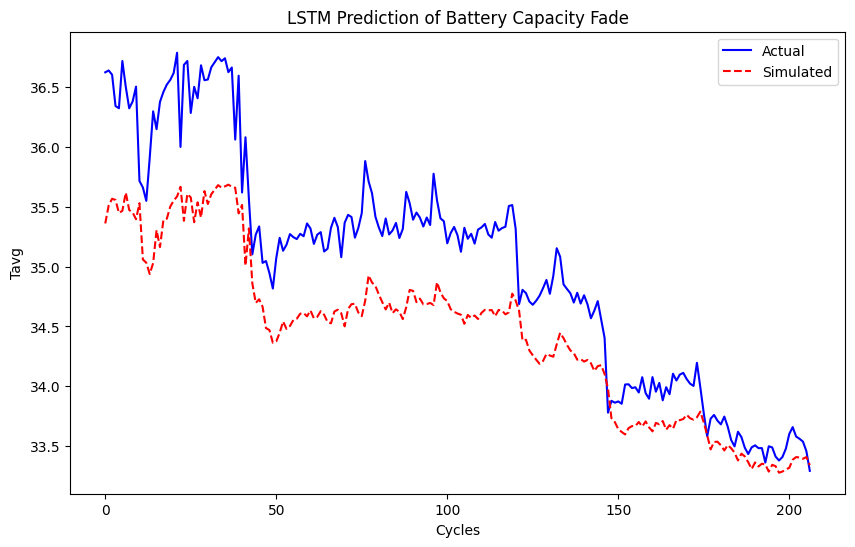

In [31]:
# Increase current value by 10%
y_sim, y_true = test_lstm(model, scaler_y, X_test*0.7483, y_test)
plot_predict(y_sim, y_true, y_title=target_name, y_label = "Simulated")